# 0.1. Import and set-up

In [1]:
import category_encoders as ce
import pandas as pd
import settings
import sys

sys.path.append('../../')

from collections import Counter
from comet_ml import Experiment
from DataScienceHelpers.DataCleaningAttributes import find_low_information_attributes
from DataScienceHelpers.DataCleaningOutliers import find_outliers_iqr
from DataScienceHelpers.ExploratoryDataAnalysis import display_qqplot_histograms
from geopy import distance
from geopy.geocoders import Nominatim
from itertools import chain
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split  

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)


# 0.2. Set-up Comet ML

In [2]:
experiment = Experiment(
  api_key=settings.API_KEY,
  project_name='hotel-reviews-analysis',
  workspace='helios12'
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/helios12/hotel-reviews-analysis/7f656de84d984127bc5eb912ec622427



# 1. Loading data

In [3]:
hotels = pd.read_csv('../../data/hotels.csv')
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [4]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,52.385601,4.847060


# 2. Data cleaning

## 2.1. Checking for and removing duplicates

In [5]:
mask = hotels.duplicated()
hotels_duplicates = hotels[mask]
display(f'Number of records including duplicates: {hotels.shape[0]}')
display(f'Number of duplicates: {hotels_duplicates.shape[0]}')
hotels = hotels.drop_duplicates()
display(f'Number of records excluding duplicates: {hotels.shape[0]}')


'Number of records including duplicates: 386803'

'Number of duplicates: 307'

'Number of records excluding duplicates: 386496'

## 2.2. Handling empty values

In [6]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 10  r

Empty values are only available in the columns 'lat' and 'lng'. It does not make sense to fill them with median or mean values. Later in the code I will be determining city and country of the hotel by parsing the 'hotel_address' column. I will use the default coordinates for the city and country using the geopy library to fill the empty values.

## 2.3. Handling outliers

Since we have more than 5000 rows of data, Shapiro-Wilk normality test is not applicable. We'll try viaual means: Q-Q plots and histograms.

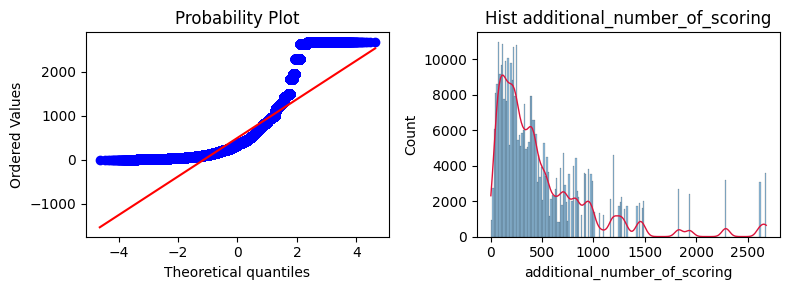

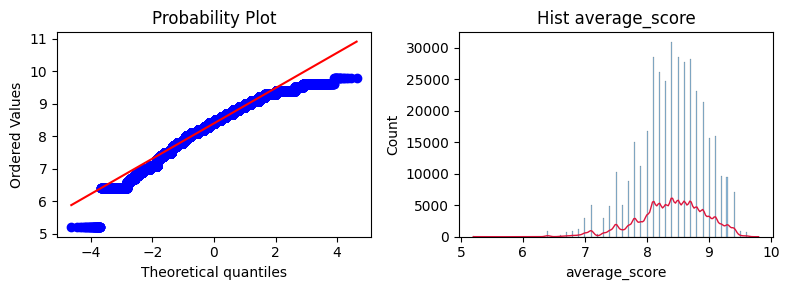

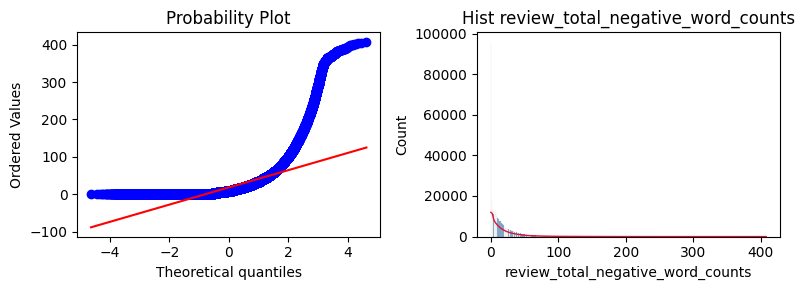

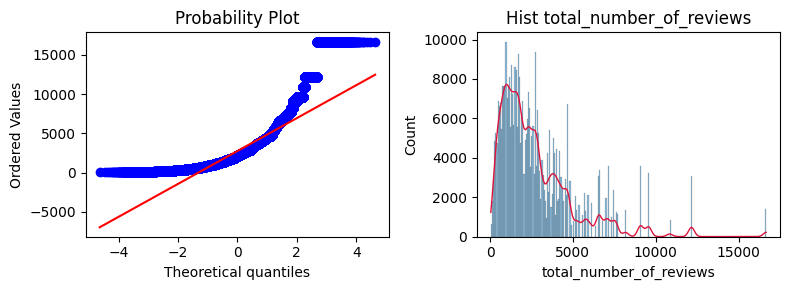

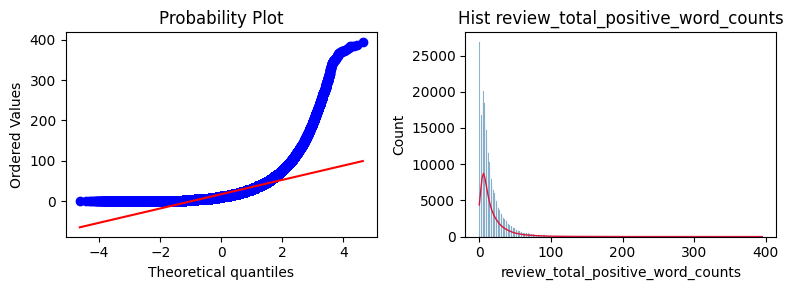

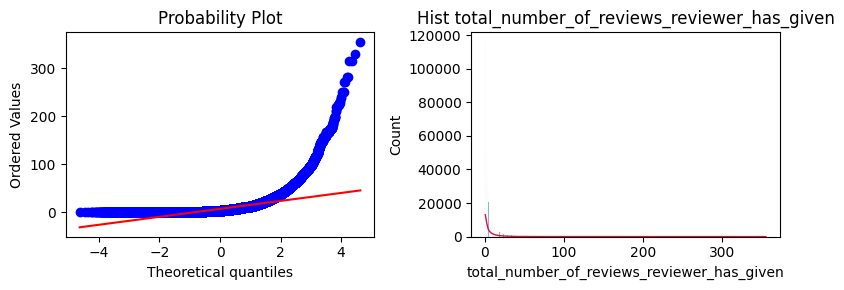

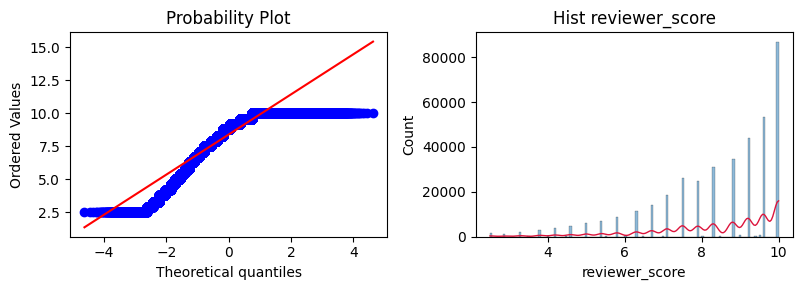

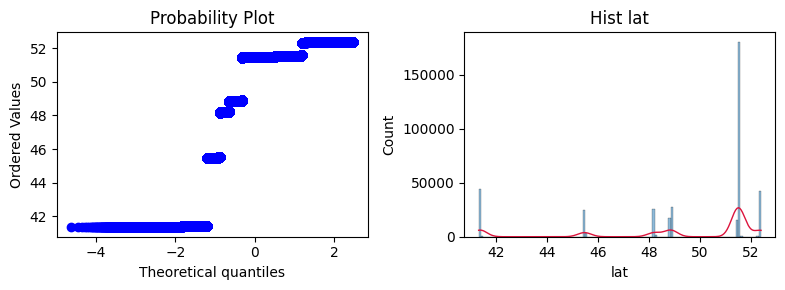

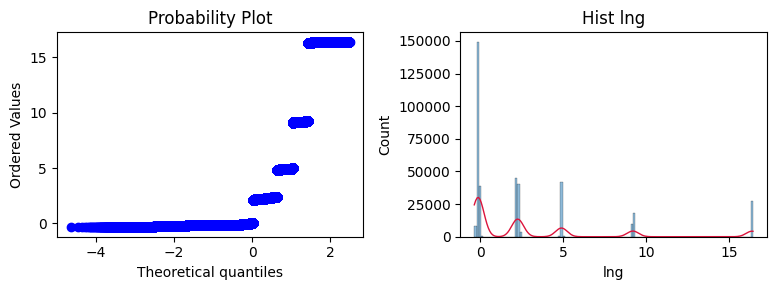

In [7]:
numeric_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
                'total_number_of_reviews', 'review_total_positive_word_counts',
                'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']
display_qqplot_histograms(hotels[numeric_cols])

Only the feature 'average_score' is close to a normal distribution. The features 'additional_number_of_scoring', 'total_number_of_reviews' and 'review_total_positive_word_counts' look like log-normal distributions. 

We'll remove the outliers only for the mentioned four features, since the used Tukey method works good for normal and log-normal distributions.

In [8]:
display(f'Number of records with outliers: {hotels.shape[0]}')

outliers, hotels = find_outliers_iqr(hotels, 'additional_number_of_scoring', log_scale=True)
display(f'Outliers additional_number_of_scoring: {outliers.shape[0]}')
outliers, hotels = find_outliers_iqr(hotels, 'average_score')
display(f'Outliers average_score: {outliers.shape[0]}')
outliers, hotels = find_outliers_iqr(hotels, 'total_number_of_reviews', log_scale=True)
display(f'Outliers total_number_of_reviews: {outliers.shape[0]}')
outliers, hotels = find_outliers_iqr(hotels, 'review_total_positive_word_counts', log_scale=True)
display(f'Outliers review_total_positive_word_counts: {outliers.shape[0]}')

display(f'Number of records without outliers: {hotels.shape[0]}')

'Number of records with outliers: 386496'

'Outliers additional_number_of_scoring: 2075'

'Outliers average_score: 7066'

'Outliers total_number_of_reviews: 1966'

'Outliers review_total_positive_word_counts: 787'

'Number of records without outliers: 374602'

## 2.4. Handling low-information attributes

In [9]:
find_low_information_attributes(hotels)

[]

None of the attributes has too many equal values or too many distinct values.

# 3. Exploratory data analysis

## 3.1. Feature engineering

### 3.1.1. Handle non-numeric data

3.1.1.1. Feature 'hotel_address'

In [10]:
def get_city_and_country(x):
    x = x.split()
    if x[-1] == 'Kingdom':
        city = x[-5]
        country = 'United Kingdom'
    else:
        city = x[-2]
        country = x[-1]
    return city, country, f'{city}, {country}'

hotels[['city', 'country', 'city_country']] = \
    hotels.apply(lambda x: get_city_and_country(x['hotel_address']), axis=1, result_type='expand')


display(f'Unique cities: {hotels['city'].unique()}')
display(f'Unique countries: {hotels['country'].unique()}')

"Unique cities: ['London' 'Paris' 'Amsterdam' 'Milan' 'Vienna' 'Barcelona']"

"Unique countries: ['United Kingdom' 'France' 'Netherlands' 'Italy' 'Austria' 'Spain']"

Neither city nor countries list does not exceed 15 elements. For this reason we'll use the One Hot encoding to encode these categorical features.

In [11]:
oh_enc = ce.OneHotEncoder(use_cat_names=True)
col_enc = oh_enc.fit_transform(hotels[['city', 'country']])
hotels = pd.concat([hotels, col_enc], axis=1)

As stated above, let's use the city and country data to get default city center coordinates for the missing 'lat' and 'lng' columns.

In [12]:
coords = {}
geolocator = Nominatim(user_agent="DG data science project 3")

for loc in hotels['city_country'].unique():
    location = geolocator.geocode(loc)
    coords[loc] = (location.latitude, location.longitude)

display('City coordinates:')
display(coords)


'City coordinates:'

{'London, United Kingdom': (51.5074456, -0.1277653),
 'Paris, France': (48.8534951, 2.3483915),
 'Amsterdam, Netherlands': (52.3730796, 4.8924534),
 'Milan, Italy': (45.4641943, 9.1896346),
 'Vienna, Austria': (48.2083537, 16.3725042),
 'Barcelona, Spain': (41.3828939, 2.1774322)}

In [13]:
hotels['lat'] = hotels.apply(lambda x: coords[x['city_country']][0] if pd.isnull(x['lat']) else x['lat'], axis=1)
hotels['lng'] = hotels.apply(lambda x: coords[x['city_country']][1] if pd.isnull(x['lng']) else x['lng'], axis=1)
hotels[['lat', 'lng']].info()


<class 'pandas.core.frame.DataFrame'>
Index: 374602 entries, 0 to 386802
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     374602 non-null  float64
 1   lng     374602 non-null  float64
dtypes: float64(2)
memory usage: 8.6 MB


#### 3.1.1.2. Feature 'review_date'

This feature will be split into multiple underlying values and encoded.

In [14]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

hotels['review_year'] = (hotels['review_date'].dt.year).apply(str)
hotels['review_month'] = (hotels['review_date'].dt.month).apply(str)
hotels['review_day'] = (hotels['review_date'].dt.day).apply(str)
hotels['review_dayofweek'] = (hotels['review_date'].dt.dayofweek.apply(str))
hotels['review_dayofyear'] = hotels['review_date'].dt.dayofyear

col_enc = oh_enc.fit_transform(hotels[['review_year', 'review_month', 'review_dayofweek']])
hotels = pd.concat([hotels, col_enc], axis=1)

bin_enc = ce.BinaryEncoder()
col_enc = bin_enc.fit_transform(hotels[['review_day']])
hotels = pd.concat([hotels, col_enc], axis=1)

#### 3.1.1.3. Feature 'hotel_name'

This feature will be rejected since it is not categorical and it cannot be parsed to get any meaningful information.

#### 3.1.1.4. Feature 'reviewer_nationality'

In [15]:
display(f'Number of nationalities: {len(hotels['reviewer_nationality'].unique())}')

'Number of nationalities: 224'

Since the number of categories is larger than 15, we use the binary encoding for this categorical feature.

In [16]:
col_enc = bin_enc.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, col_enc], axis=1)

#### 3.1.1.5. Features 'negative_review' and 'positive review'

I could not find a way to parse these strings to get some meaningful information.

However I noticed that the values in columns 'review_total_negative_word_counts' and 'review_total_positive_word_counts' do not match the count of words in the corresponding text columns. Let's fix this.

In [17]:
zero_words_negative = ['no negative', 'nothing', 'n a', 'none', '', 'all good', 
                       'nothing really', 'no complaints', 'nil', 'Nothing to dislike',
                       'nothing at all', 'na', 'can t think of anything']
zero_words_positive = ['no positive', 'nothing']

hotels['review_total_negative_word_counts'] = \
    hotels['negative_review'].apply(lambda x: 0 if x.strip().lower() in zero_words_negative else len(x.split()))
hotels['review_total_positive_word_counts'] = \
    hotels['positive_review'].apply(lambda x: 0 if x.strip().lower() in zero_words_positive else len(x.split()))

#### 3.1.1.6. Feature 'tags'

In [18]:
c = Counter(list(chain(*[x[3:-3].split(' \', \' ') for x in hotels['tags']])))
popular_tags = dict(c.most_common(10))
display(f'Popular tags: {popular_tags}')

df_tags = pd.DataFrame(
    data = list(hotels['tags'].apply(lambda x: [1 if pt in x else 0 for pt in popular_tags])),
    columns= list(popular_tags.keys())
)

hotels.reset_index(drop=True, inplace=True)
hotels = pd.concat([hotels, df_tags], axis=1)

"Popular tags: {'Leisure trip': 304534, 'Submitted from a mobile device': 223990, 'Couple': 183961, 'Stayed 1 night': 140614, 'Stayed 2 nights': 97175, 'Solo traveler': 77666, 'Stayed 3 nights': 69832, 'Business trip': 59289, 'Group': 47652, 'Family with young children': 44495}"

#### 3.1.1.7. Feature 'days_since_review'

In [19]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

### 3.1.2. Handling numeric features

#### 3.1.2.1. Features 'lat' and 'lng'

In addition to hotel coordinates, we'll calculate the distance to the corresponding city center.

In [20]:
hotels['city_cetnter_distance'] = \
    hotels.apply(lambda x: distance.distance(coords[x['city_country']], (x['lat'], x['lng'])).km, axis=1)

#### 3.1.2.2. Normalization and standardization

For the columns 'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng' the normality has been checked above. The following approach will be taken based on the normality:

Normalization: 'additional_number_of_scoring', , 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng'

Standardization: 'average_score'

Analyze for normality updated columns: 'review_total_negative_word_counts', 'review_total_positive_word_counts'

Analyze for normality new columns: 'days_since_review', 'city_cetnter_distance', 'review_dayofyear'

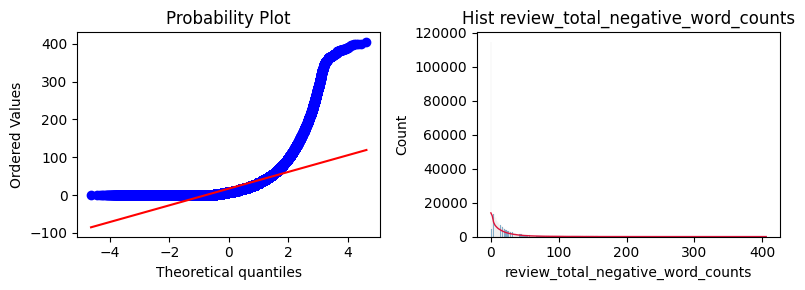

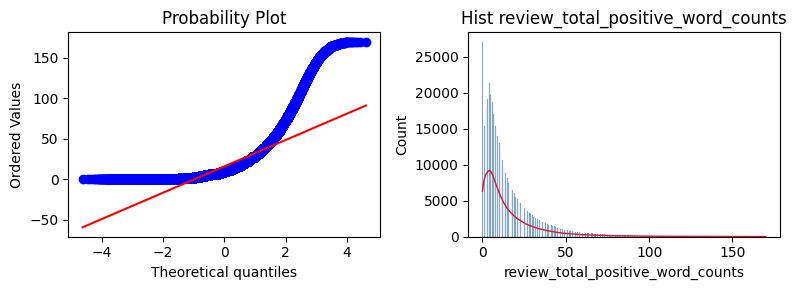

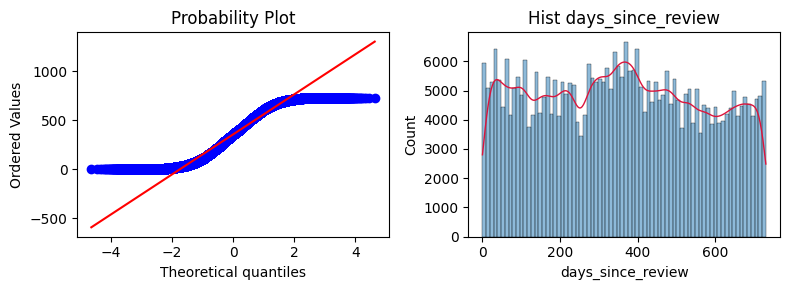

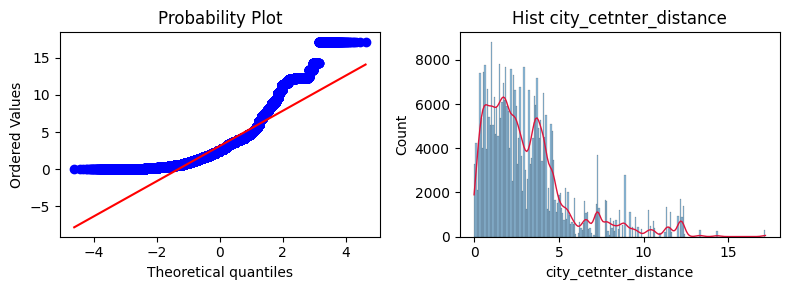

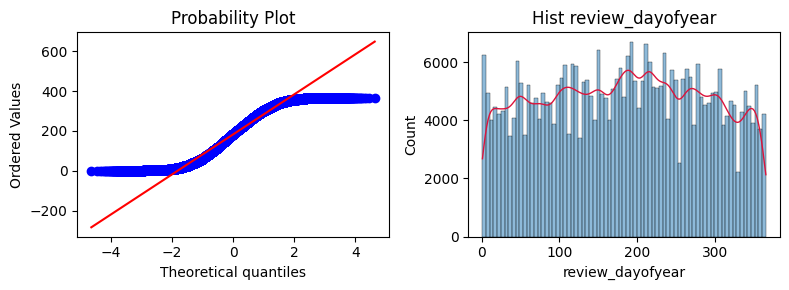

In [21]:
numeric_cols = [
    'review_total_negative_word_counts', 'review_total_positive_word_counts', 
    'days_since_review', 'city_cetnter_distance', 'review_dayofyear'
]
display_qqplot_histograms(hotels[numeric_cols])

None of the columns has a normal distribution, thus the following approaches will be taken:

Normalization: 'additional_number_of_scoring', , 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'days_since_review', 'city_cetnter_distance', 'review_dayofyear'

Standardization: 'average_score'

In [22]:
# Use MinMaxScaler for columns cleaned from the outliers
mm_scaler_cols = \
    ['additional_number_of_scoring', 'total_number_of_reviews', 'review_total_positive_word_counts']
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(hotels[mm_scaler_cols])
df_mm = pd.DataFrame(df_mm, columns=mm_scaler_cols)

# Use RobustScaler for other columns
r_scaler_cols = [
    'total_number_of_reviews_reviewer_has_given', 
    'lat', 'lng', 'review_total_negative_word_counts', 
    'days_since_review', 'city_cetnter_distance', 'review_dayofyear'
]
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(hotels[r_scaler_cols])
df_r = pd.DataFrame(df_r, columns=r_scaler_cols)

# Use StandardScaler to scale the hormal data
s_scaler_cols = ['average_score']
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(hotels[s_scaler_cols])
df_s = pd.DataFrame(df_s, columns=s_scaler_cols)

hotels.drop(mm_scaler_cols, axis=1, inplace=True)
hotels.drop(r_scaler_cols, axis=1, inplace=True)
hotels.drop(s_scaler_cols, axis=1, inplace=True)
hotels = pd.concat([hotels, df_mm, df_r, df_s], axis=1)

In [23]:
hotels.head(10)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,total_number_of_reviews,positive_review,review_total_positive_word_counts,reviewer_score,tags,city,country,city_country,city_London,city_Paris,city_Amsterdam,city_Milan,city_Vienna,city_Barcelona,country_United Kingdom,country_France,country_Netherlands,country_Italy,country_Austria,country_Spain,review_year,review_month,review_day,review_dayofweek,review_year_2016,review_year_2017,review_year_2015,review_month_2,review_month_1,review_month_10,review_month_9,review_month_3,review_month_12,review_month_5,review_month_11,review_month_6,review_month_7,review_month_4,review_month_8,review_dayofweek_4,review_dayofweek_3,review_dayofweek_1,review_dayofweek_5,review_dayofweek_2,review_dayofweek_0,review_dayofweek_6,review_day_0,review_day_1,review_day_2,review_day_3,review_day_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,Leisure trip,Submitted from a mobile device,Couple,Stayed 1 night,Stayed 2 nights,Solo traveler,Stayed 3 nights,Business trip,Group,Family with young children,total_number_of_reviews_reviewer_has_given,lat,lng,review_total_negative_word_counts,days_since_review,city_cetnter_distance,review_dayofyear
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,1994,Staff were amazing,3,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",London,United Kingdom,"London, United Kingdom",1,0,0,0,0,0,1,0,0,0,0,0,2016,2,19,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0.571429,0.002398,-0.032818,-0.285714,0.505714,-0.508879,-0.784884
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,1361,location,1,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",London,United Kingdom,"London, United Kingdom",1,0,0,0,0,0,1,0,0,0,0,0,2017,1,12,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1.571429,0.006365,-0.028690,-0.238095,-0.431429,-0.350296,-1.005814
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,406,No Positive,0,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",Paris,France,"Paris, France",0,1,0,0,0,0,0,1,0,0,0,0,2016,10,18,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1.571429,-0.803094,0.462653,-0.142857,-0.185714,-0.221894,0.622093
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,607,Friendly staff quiet comfortable room spotlessly clean excellent location,9,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",Paris,France,"Paris, France",0,1,0,0,0,0,0,1,0,0,0,0,2015,9,22,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0.714286,-0.789988,0.476477,-0.333333,0.934286,0.964852,0.465116
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,18,9.6,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",Amsterdam,Netherlands,"Amsterdam, Netherlands",0,0,1,0,0,0,0,0,1,0,0,0,2016,3,5,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1.000000,0.267931,0.968578,-0.238095,0.462857,0.318560,-0.697674
5,Via Mece

In [24]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes in ['object', 'datetime64[ns]']]
hotels.drop(object_columns, axis = 1, inplace=True)

In [25]:
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']  
    
# Usual test size is 0.3, 0.25, 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [26]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374602 entries, 0 to 374601
Data columns (total 69 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                374602 non-null  int64  
 1   average_score                               374602 non-null  float64
 2   total_number_of_reviews                     374602 non-null  int64  
 3   review_total_positive_word_counts           374602 non-null  int64  
 4   reviewer_score                              374602 non-null  float64
 5   city_London                                 374602 non-null  int64  
 6   city_Paris                                  374602 non-null  int64  
 7   city_Amsterdam                              374602 non-null  int64  
 8   city_Milan                                  374602 non-null  int64  
 9   city_Vienna                                 374602 non-null  int64  
 

In [27]:
regr = RandomForestRegressor(n_estimators=100)  

# train the model
regr.fit(X_train, y_train)  

# use a trained model for the test data      
y_pred = regr.predict(X_test)


In [28]:
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
experiment.log_metrics({'MAPE': mape})

In [29]:
mape

0.13387454516099787

In [30]:
# Finalize Comet ML
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : reliable_plywood_9338
COMET INFO:     url                   : https://www.comet.com/helios12/hotel-reviews-analysis/7f656de84d984127bc5eb912ec622427
COMET INFO:   Metrics:
COMET INFO:     MAPE : 0.13387454516099787
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     copy                     : True
COMET INFO:     criterion                : squared_error
COMET INFO:     max_depth                : None
COMET INFO:     max_features             : 1.0
COMET INFO:     max_leaf_nodes           : None
COMET INFO:     max_samples              : None
COMET INFO:     min_impuri